In [ ]:
# Retrieval sanity experiment on Jetson Nano
Use the cells below to run the PMFlow vs baseline retrieval sanity loop directly on the GPU-equipped Jetson Nano. Adjust parameters as needed before executing.

In [11]:
from pathlib import Path
from typing import Optional
import os
import sys


def ensure_pmflow() -> object:
    """Return the pmflow_bnn module, trying pip install first then local fallbacks."""
    try:
        import pmflow_bnn  # type: ignore
        version = getattr(pmflow_bnn, "__version__", "unknown")
        print(f"Using pip-installed pmflow-bnn=={version}")
        return pmflow_bnn
    except ImportError:
        pass

    candidates = []
    env_root = os.environ.get("PMFLOW_LIB_ROOT")
    if env_root:
        candidates.append(Path(env_root))

    default_base = Path.cwd()
    candidates.extend(
        [
            default_base,
            default_base / "Pushing-Medium" / "programs" / "demos" / "machine_learning" / "nn_lib_v2",
            Path.home() / "Pushing-Medium" / "programs" / "demos" / "machine_learning" / "nn_lib_v2",
            Path("/home/tmumford/Coding/LLM/lilith/Pushing-Medium/programs/demos/machine_learning/nn_lib_v2"),
        ]
    )

    for base in candidates:
        pkg = Path(base) / "pmflow_bnn"
        if pkg.exists():
            if str(base) not in sys.path:
                sys.path.insert(0, str(base))
            import pmflow_bnn  # type: ignore
            version = getattr(pmflow_bnn, "__version__", "unknown")
            print(f"Using pmflow_bnn from local path: {base} (version {version})")
            return pmflow_bnn

    raise ImportError(
        "pmflow-bnn is not available. Install it with `pip install pmflow-bnn` or set "
        "PMFLOW_LIB_ROOT to the directory containing the pmflow_bnn package before running this cell."
    )


pmflow_bnn = ensure_pmflow()
PMFLOW_PACKAGE_ROOT = Path(pmflow_bnn.__file__).resolve().parent
print("pmflow_bnn package root:", PMFLOW_PACKAGE_ROOT)

Using pip-installed pmflow-bnn==0.2.0
pmflow_bnn package root: /home/tmumford/.virtualenvs/deepstream5/lib/python3.6/site-packages/pmflow_bnn


In [12]:
import json
import math
import random
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from pmflow_bnn.pmflow import ParallelPMField


# ---------------------------------------------------------------------------
# Data utilities
# ---------------------------------------------------------------------------


def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


@dataclass
class DatasetSplit:
    support_x: torch.Tensor
    support_y: torch.Tensor
    query_x: torch.Tensor
    query_y: torch.Tensor


def make_symbol_dataset(
    num_classes: int = 3,
    points_per_class: int = 90,
    support_ratio: float = 0.6,
    cluster_std: float = 0.55,
    seed: int = 42,
) -> DatasetSplit:
    set_seed(seed)
    centers: List[Tuple[float, float]] = []
    angle_step = 2 * math.pi / num_classes
    radius = 3.0
    for i in range(num_classes):
        angle = i * angle_step
        centers.append((radius * math.cos(angle), radius * math.sin(angle)))

    features: List[np.ndarray] = []
    labels: List[int] = []
    for class_idx, (cx, cy) in enumerate(centers):
        points = np.random.randn(points_per_class, 2) * cluster_std
        points += np.array([cx, cy])
        features.append(points)
        labels.extend([class_idx] * points_per_class)

    X = torch.tensor(np.vstack(features), dtype=torch.float32)
    y = torch.tensor(labels, dtype=torch.long)

    X = (X - X.mean(dim=0, keepdim=True)) / (X.std(dim=0, keepdim=True) + 1e-6)

    support_x_list: List[torch.Tensor] = []
    support_y_list: List[torch.Tensor] = []
    query_x_list: List[torch.Tensor] = []
    query_y_list: List[torch.Tensor] = []

    for class_idx in range(num_classes):
        class_mask = y == class_idx
        class_indices = class_mask.nonzero(as_tuple=False).squeeze(1)
        perm = class_indices[torch.randperm(class_indices.shape[0])]
        split_point = int(len(perm) * support_ratio)
        support_idx = perm[:split_point]
        query_idx = perm[split_point:]
        support_x_list.append(X[support_idx])
        support_y_list.append(y[support_idx])
        query_x_list.append(X[query_idx])
        query_y_list.append(y[query_idx])

    return DatasetSplit(
        support_x=torch.vstack(support_x_list),
        support_y=torch.hstack(support_y_list),
        query_x=torch.vstack(query_x_list),
        query_y=torch.hstack(query_y_list),
    )


def load_relational_export(
    path: Path,
    support_ratio: float = 0.6,
    seed: int = 42,
) -> DatasetSplit:
    with path.open() as f:
        data = json.load(f)

    entries = data.get("entries", [])
    if not entries:
        raise ValueError(f"No entries found in relational export {path}")

    class_names = sorted({entry["class"] for entry in entries})
    class_to_idx = {name: idx for idx, name in enumerate(class_names)}

    features = torch.tensor([entry["coords"] for entry in entries], dtype=torch.float32)
    labels = torch.tensor([class_to_idx[entry["class"]] for entry in entries], dtype=torch.long)
    features = (features - features.mean(dim=0, keepdim=True)) / (features.std(dim=0, keepdim=True) + 1e-6)

    set_seed(seed)

    support_x_list: List[torch.Tensor] = []
    support_y_list: List[torch.Tensor] = []
    query_x_list: List[torch.Tensor] = []
    query_y_list: List[torch.Tensor] = []

    for class_idx in range(len(class_names)):
        class_mask = labels == class_idx
        class_indices = class_mask.nonzero(as_tuple=False).squeeze(1)
        perm = class_indices[torch.randperm(class_indices.shape[0])]
        split_point = max(1, int(len(perm) * support_ratio))
        support_idx = perm[:split_point]
        query_idx = perm[split_point:] if split_point < len(perm) else perm[split_point - 1 :]
        support_x_list.append(features[support_idx])
        support_y_list.append(labels[support_idx])
        if len(query_idx) > 0:
            query_x_list.append(features[query_idx])
            query_y_list.append(labels[query_idx])

    if not query_x_list:
        raise ValueError("Relational dataset split produced an empty query set")

    return DatasetSplit(
        support_x=torch.vstack(support_x_list),
        support_y=torch.hstack(support_y_list),
        query_x=torch.vstack(query_x_list),
        query_y=torch.hstack(query_y_list),
    )


# ---------------------------------------------------------------------------
# Embedding models and helpers
# ---------------------------------------------------------------------------


class VectorStore:
    def __init__(self, metric: str = "cosine") -> None:
        if metric not in {"cosine", "euclidean"}:
            raise ValueError(f"Unsupported metric '{metric}'")
        self.metric = metric
        self._embeddings: Optional[torch.Tensor] = None
        self._labels: Optional[torch.Tensor] = None

    def clear(self) -> None:
        self._embeddings = None
        self._labels = None

    def add(self, embeddings: torch.Tensor, labels: torch.Tensor) -> None:
        embeddings = embeddings.detach()
        labels = labels.detach()
        if self._embeddings is None or self._labels is None:
            self._embeddings = embeddings
            self._labels = labels
        else:
            self._embeddings = torch.cat([self._embeddings, embeddings], dim=0)
            self._labels = torch.cat([self._labels, labels], dim=0)

    def search(self, queries: torch.Tensor, topk: int = 1) -> Tuple[torch.Tensor, torch.Tensor]:
        if self._embeddings is None or self._labels is None:
            raise RuntimeError("VectorStore is empty")

        embeddings = self._embeddings.to(queries.device)
        if self.metric == "cosine":
            support = F.normalize(embeddings, p=2, dim=1)
            q_norm = F.normalize(queries, p=2, dim=1)
            scores = q_norm @ support.T
            values, indices = scores.topk(topk, dim=1)
        else:
            distances = torch.cdist(queries, embeddings)
            values, indices = (-distances).topk(topk, dim=1)

        labels = self._labels.to(queries.device)
        top_labels = labels[indices]
        return values, top_labels


class LinearEmbeddingNet(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int, num_classes: int) -> None:
        super().__init__()
        self.embed = nn.Sequential(nn.Linear(input_dim, latent_dim), nn.Tanh())
        self.head = nn.Linear(latent_dim, num_classes)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        z = self.embed(x)
        logits = self.head(z)
        return logits, z


class PMFlowEmbeddingNet(nn.Module):
    def __init__(
        self,
        input_dim: int,
        latent_dim: int,
        num_classes: int,
        n_centers: int = 24,
        pm_steps: int = 4,
        dt: float = 0.12,
        beta: float = 1.1,
        clamp: float = 3.0,
    ) -> None:
        super().__init__()
        self.embed = nn.Sequential(nn.Linear(input_dim, latent_dim), nn.Tanh())
        self.pm = ParallelPMField(
            d_latent=latent_dim,
            n_centers=n_centers,
            steps=pm_steps,
            dt=dt,
            beta=beta,
            clamp=clamp,
            temporal_parallel=False,
        )
        self.head = nn.Linear(latent_dim, num_classes)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        z0 = self.embed(x)
        z = self.pm(z0)
        logits = self.head(z)
        return logits, z


def train_classifier(
    model: nn.Module,
    train_x: torch.Tensor,
    train_y: torch.Tensor,
    epochs: int = 600,
    lr: float = 2e-3,
    weight_decay: float = 1e-4,
) -> Dict[str, object]:
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    history: List[Dict[str, float]] = []
    last_loss = float("nan")

    for epoch in range(epochs):
        optimizer.zero_grad()
        logits, _ = model(train_x)
        loss = criterion(logits, train_y)
        loss.backward()
        optimizer.step()
        last_loss = float(loss.item())

        if (epoch + 1) % max(1, epochs // 5) == 0 or epoch == 0:
            acc = accuracy(model, train_x, train_y)
            history.append({"epoch": float(epoch + 1), "loss": last_loss, "acc": float(acc)})

    return {"final_loss": last_loss, "history": history}


def accuracy(model: nn.Module, x: torch.Tensor, y: torch.Tensor) -> float:
    model.eval()
    with torch.no_grad():
        logits, _ = model(x)
        preds = logits.argmax(dim=1)
        return (preds == y).float().mean().item()

In [16]:
from typing import Dict, List, Optional

DEFAULT_ARGS: Dict[str, str] = {
    "data-mode": "synthetic",  # or "relational"
    "support-ratio": "0.6",
    "cluster-std": "0.55",
    "points-per-class": "90",
    "num-classes": "3",
    "epochs": "400",
    "latent-dim": "16",
    "pm-steps": "4",
    "n-centers": "32",
    "metric": "cosine",
    "relational-path": str(Path.cwd() / "relational_export.json"),
}


def run_retrieval(overrides: Optional[Dict[str, str]] = None, *, verbose: bool = True) -> dict:
    overrides = overrides or {}
    config = {**DEFAULT_ARGS, **overrides}

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data_mode = config["data-mode"]
    support_ratio = float(config["support-ratio"])
    cluster_std = float(config["cluster-std"])
    points_per_class = int(config["points-per-class"])
    num_classes_cfg = int(config["num-classes"])
    epochs = int(config["epochs"])
    latent_dim = int(config["latent-dim"])
    pm_steps = int(config["pm-steps"])
    n_centers = int(config["n-centers"])
    metric = config["metric"]
    relational_path = config["relational-path"]

    if data_mode == "synthetic":
        split = make_symbol_dataset(
            num_classes=num_classes_cfg,
            points_per_class=points_per_class,
            support_ratio=support_ratio,
            cluster_std=cluster_std,
            seed=42,
        )
    elif data_mode == "relational":
        rel_path = Path(relational_path).expanduser()
        if not rel_path.exists():
            raise FileNotFoundError(f"Relational export not found at {rel_path}")
        split = load_relational_export(rel_path, support_ratio=support_ratio, seed=42)
    else:
        raise ValueError(f"Unknown data mode '{data_mode}'")

    train_x = split.support_x.to(device)
    train_y = split.support_y.to(device)
    query_x = split.query_x.to(device)
    query_y = split.query_y.to(device)

    input_dim = train_x.shape[1]
    num_classes = int(max(train_y.max(), query_y.max()).item() + 1)

    baseline = LinearEmbeddingNet(input_dim=input_dim, latent_dim=latent_dim, num_classes=num_classes).to(device)
    pm_model = PMFlowEmbeddingNet(
        input_dim=input_dim,
        latent_dim=latent_dim,
        num_classes=num_classes,
        n_centers=n_centers,
        pm_steps=pm_steps,
        dt=0.12,
        beta=1.1,
        clamp=3.0,
    ).to(device)

    baseline_train = train_classifier(baseline, train_x, train_y, epochs=epochs)
    pm_train = train_classifier(pm_model, train_x, train_y, epochs=epochs)

    baseline_store = VectorStore(metric=metric)
    pm_store = VectorStore(metric=metric)

    with torch.no_grad():
        _, baseline_support_embed = baseline(train_x)
        _, baseline_query_embed = baseline(query_x)
        _, pm_support_embed = pm_model(train_x)
        _, pm_query_embed = pm_model(query_x)

    baseline_store.add(baseline_support_embed, train_y)
    pm_store.add(pm_support_embed, train_y)

    baseline_class_acc = accuracy(baseline, query_x, query_y)
    pm_class_acc = accuracy(pm_model, query_x, query_y)

    _, baseline_labels = baseline_store.search(baseline_query_embed, topk=1)
    _, pm_labels = pm_store.search(pm_query_embed, topk=1)

    baseline_retrieval = (baseline_labels.squeeze(1) == query_y).float().mean().item()
    pm_retrieval = (pm_labels.squeeze(1) == query_y).float().mean().item()

    resolved_config = {
        "data_mode": data_mode,
        "support_ratio": support_ratio,
        "cluster_std": cluster_std,
        "points_per_class": points_per_class,
        "num_classes": num_classes_cfg,
        "epochs": epochs,
        "latent_dim": latent_dim,
        "pm_steps": pm_steps,
        "n_centers": n_centers,
        "metric": metric,
        "relational_path": str(Path(relational_path)),
    }

    metrics = {
        "baseline": {
            "class_accuracy": baseline_class_acc,
            "retrieval_accuracy": baseline_retrieval,
            "final_loss": baseline_train["final_loss"],
        },
        "pmflow": {
            "class_accuracy": pm_class_acc,
            "retrieval_accuracy": pm_retrieval,
            "final_loss": pm_train["final_loss"],
        },
    }

    training_history = {
        "baseline": baseline_train["history"],
        "pmflow": pm_train["history"],
    }

    dataset_info = {
        "support_samples": int(train_x.shape[0]),
        "query_samples": int(query_x.shape[0]),
        "input_dim": int(input_dim),
        "num_classes": num_classes,
    }

    results = {
        "config": resolved_config,
        "metrics": metrics,
        "training_history": training_history,
        "dataset": dataset_info,
        "device": str(device),
    }

    if verbose:
        print(json.dumps(results, indent=2, default=str))
    return results


results = run_retrieval()
results

{
  "config": {
    "data_mode": "synthetic",
    "support_ratio": 0.6,
    "cluster_std": 0.55,
    "points_per_class": 90,
    "num_classes": 3,
    "epochs": 400,
    "latent_dim": 16,
    "pm_steps": 4,
    "n_centers": 32,
    "metric": "cosine",
    "relational_path": "/home/tmumford/relational_export.json"
  },
  "metrics": {
    "baseline": {
      "class_accuracy": 1.0,
      "retrieval_accuracy": 1.0,
      "final_loss": 0.018624799326062202
    },
    "pmflow": {
      "class_accuracy": 1.0,
      "retrieval_accuracy": 1.0,
      "final_loss": 0.036087263375520706
    }
  },
  "training_history": {
    "baseline": [
      {
        "epoch": 1.0,
        "loss": 1.2907207012176514,
        "acc": 0.07407407462596893
      },
      {
        "epoch": 80.0,
        "loss": 0.42377156019210815,
        "acc": 1.0
      },
      {
        "epoch": 160.0,
        "loss": 0.11931664496660233,
        "acc": 1.0
      },
      {
        "epoch": 240.0,
        "loss": 0.051232561469

{'config': {'data_mode': 'synthetic',
  'support_ratio': 0.6,
  'cluster_std': 0.55,
  'points_per_class': 90,
  'num_classes': 3,
  'epochs': 400,
  'latent_dim': 16,
  'pm_steps': 4,
  'n_centers': 32,
  'metric': 'cosine',
  'relational_path': '/home/tmumford/relational_export.json'},
 'metrics': {'baseline': {'class_accuracy': 1.0,
   'retrieval_accuracy': 1.0,
   'final_loss': 0.018624799326062202},
  'pmflow': {'class_accuracy': 1.0,
   'retrieval_accuracy': 1.0,
   'final_loss': 0.036087263375520706}},
 'training_history': {'baseline': [{'epoch': 1.0,
    'loss': 1.2907207012176514,
    'acc': 0.07407407462596893},
   {'epoch': 80.0, 'loss': 0.42377156019210815, 'acc': 1.0},
   {'epoch': 160.0, 'loss': 0.11931664496660233, 'acc': 1.0},
   {'epoch': 240.0, 'loss': 0.051232561469078064, 'acc': 1.0},
   {'epoch': 320.0, 'loss': 0.028770990669727325, 'acc': 1.0},
   {'epoch': 400.0, 'loss': 0.018624799326062202, 'acc': 1.0}],
  'pmflow': [{'epoch': 1.0,
    'loss': 0.973081350326538

In [ ]:
import json
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Optional

from experiments.retrieval_sanity.provenance import collect_provenance

LOG_PATH = Path.cwd() / "retrieval_runs.log"
PLOT_DIR = Path.cwd() / "retrieval_plots"
EXPORT_FORMAT = "png"

if "history" not in globals():
    history: List[Dict[str, object]] = []
else:
    history = list(history)


def _compact_metrics(result: Dict[str, object]) -> Dict[str, object]:
    metrics = result.get("metrics", {})
    baseline = metrics.get("baseline", {})
    pmflow = metrics.get("pmflow", {})
    keys = ("class_accuracy", "retrieval_accuracy", "final_loss")
    return {
        "baseline": {key: baseline.get(key) for key in keys if key in baseline},
        "pmflow": {key: pmflow.get(key) for key in keys if key in pmflow},
    }


def log_run(result: Dict[str, object], *, log_path: Path = LOG_PATH) -> None:
    log_path.parent.mkdir(parents=True, exist_ok=True)
    payload = {
        "timestamp": datetime.utcnow().isoformat() + "Z",
        "config": result.get("config"),
        "metrics": _compact_metrics(result),
        "device": result.get("device"),
        "dataset": result.get("dataset"),
        "provenance": collect_provenance(
            runner="notebook",
            device=result.get("device"),
            extra={"source": "pmflow_retrieval_lab"},
        ),
    }
    with log_path.open("a", encoding="utf-8") as fh:
        fh.write(json.dumps(payload) + "\n")


def register_run(result: Dict[str, object], *, persist: bool = True) -> Dict[str, object]:
    history.append(result)
    if persist:
        log_run(result)
    return result


def run_and_log(
    overrides: Optional[Dict[str, str]] = None, *, verbose: bool = True, persist: bool = True
) -> Dict[str, object]:
    result = run_retrieval(overrides=overrides, verbose=verbose)
    return register_run(result, persist=persist)


latest = register_run(results)
print(f"Logged run #{len(history)} to {LOG_PATH}")
latest

Logged run #3 to /home/tmumford/retrieval_runs.log


{'config': {'data_mode': 'synthetic',
  'support_ratio': 0.6,
  'cluster_std': 0.55,
  'points_per_class': 90,
  'num_classes': 3,
  'epochs': 400,
  'latent_dim': 16,
  'pm_steps': 4,
  'n_centers': 32,
  'metric': 'cosine',
  'relational_path': '/home/tmumford/relational_export.json'},
 'metrics': {'baseline': {'class_accuracy': 1.0,
   'retrieval_accuracy': 1.0,
   'final_loss': 0.018624799326062202},
  'pmflow': {'class_accuracy': 1.0,
   'retrieval_accuracy': 1.0,
   'final_loss': 0.036087263375520706}},
 'training_history': {'baseline': [{'epoch': 1.0,
    'loss': 1.2907207012176514,
    'acc': 0.07407407462596893},
   {'epoch': 80.0, 'loss': 0.42377156019210815, 'acc': 1.0},
   {'epoch': 160.0, 'loss': 0.11931664496660233, 'acc': 1.0},
   {'epoch': 240.0, 'loss': 0.051232561469078064, 'acc': 1.0},
   {'epoch': 320.0, 'loss': 0.028770990669727325, 'acc': 1.0},
   {'epoch': 400.0, 'loss': 0.018624799326062202, 'acc': 1.0}],
  'pmflow': [{'epoch': 1.0,
    'loss': 0.973081350326538

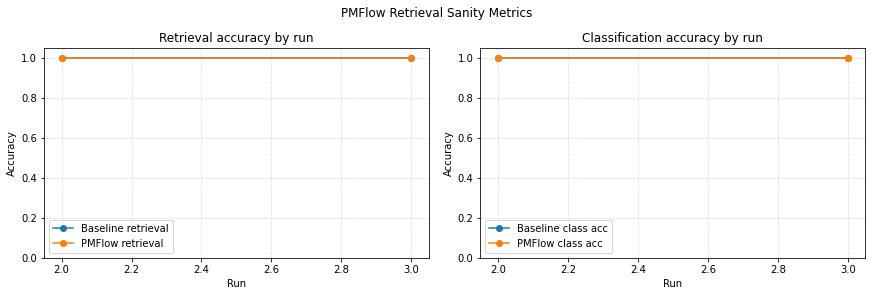

Saved plot to /home/tmumford/retrieval_plots/run-summary-20251006-235208.png


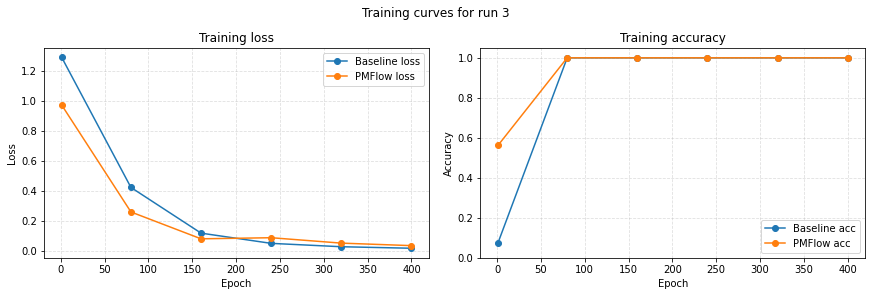

Saved plot to /home/tmumford/retrieval_plots/training-run3-20251006-235211.png


PosixPath('/home/tmumford/retrieval_plots/training-run3-20251006-235211.png')

In [18]:
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Optional


def _resolve_plot_dir() -> Path:
    directory = globals().get("PLOT_DIR", Path.cwd() / "retrieval_plots")
    directory = Path(directory)
    directory.mkdir(parents=True, exist_ok=True)
    return directory


def _resolve_export_format() -> str:
    return str(globals().get("EXPORT_FORMAT", "png"))


def _save_figure(fig: plt.Figure, stem: str) -> Path:
    directory = _resolve_plot_dir()
    timestamp = datetime.utcnow().strftime("%Y%m%d-%H%M%S")
    export_format = _resolve_export_format()
    path = directory / f"{stem}-{timestamp}.{export_format}"
    fig.savefig(path, dpi=150)
    print(f"Saved plot to {path}")
    return path


def _extract_metric(history_items: List[Dict[str, object]], model: str, key: str) -> List[float]:
    values: List[float] = []
    for item in history_items:
        model_metrics = item.get("metrics", {}).get(model, {})
        value = model_metrics.get(key)
        values.append(float(value) if value is not None else float("nan"))
    return values


def plot_runs(history_items: List[Dict[str, object]], *, save: bool = True) -> Optional[Path]:
    if not history_items:
        raise ValueError("No runs logged yet. Execute run_and_log() first.")

    run_ids = list(range(1, len(history_items) + 1))
    baseline_retrieval = _extract_metric(history_items, "baseline", "retrieval_accuracy")
    pm_retrieval = _extract_metric(history_items, "pmflow", "retrieval_accuracy")
    baseline_class = _extract_metric(history_items, "baseline", "class_accuracy")
    pm_class = _extract_metric(history_items, "pmflow", "class_accuracy")

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

    axes[0].plot(run_ids, baseline_retrieval, marker="o", label="Baseline retrieval")
    axes[0].plot(run_ids, pm_retrieval, marker="o", label="PMFlow retrieval")
    axes[0].set_xlabel("Run")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_title("Retrieval accuracy by run")
    axes[0].set_ylim(0.0, 1.05)
    axes[0].grid(True, linestyle="--", alpha=0.4)
    axes[0].legend()

    axes[1].plot(run_ids, baseline_class, marker="o", label="Baseline class acc")
    axes[1].plot(run_ids, pm_class, marker="o", label="PMFlow class acc")
    axes[1].set_xlabel("Run")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title("Classification accuracy by run")
    axes[1].set_ylim(0.0, 1.05)
    axes[1].grid(True, linestyle="--", alpha=0.4)
    axes[1].legend()

    fig.suptitle("PMFlow Retrieval Sanity Metrics")
    plt.show()

    if save:
        return _save_figure(fig, "run-summary")
    return None


def plot_training_curves(run_index: int = -1, *, save: bool = True) -> Optional[Path]:
    if not history:
        raise ValueError("No runs logged yet.")

    target = history[run_index]
    training = target.get("training_history", {})
    baseline_hist = training.get("baseline", []) or []
    pm_hist = training.get("pmflow", []) or []

    if not baseline_hist and not pm_hist:
        raise ValueError("Selected run does not contain training history.")

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

    if baseline_hist:
        axes[0].plot(
            [entry["epoch"] for entry in baseline_hist],
            [entry["loss"] for entry in baseline_hist],
            marker="o",
            label="Baseline loss",
        )
    if pm_hist:
        axes[0].plot(
            [entry["epoch"] for entry in pm_hist],
            [entry["loss"] for entry in pm_hist],
            marker="o",
            label="PMFlow loss",
        )
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Training loss")
    axes[0].grid(True, linestyle="--", alpha=0.4)
    axes[0].legend()

    if baseline_hist:
        axes[1].plot(
            [entry["epoch"] for entry in baseline_hist],
            [entry["acc"] for entry in baseline_hist],
            marker="o",
            label="Baseline acc",
        )
    if pm_hist:
        axes[1].plot(
            [entry["epoch"] for entry in pm_hist],
            [entry["acc"] for entry in pm_hist],
            marker="o",
            label="PMFlow acc",
        )
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title("Training accuracy")
    axes[1].set_ylim(0.0, 1.05)
    axes[1].grid(True, linestyle="--", alpha=0.4)
    axes[1].legend()

    title_index = len(history) if run_index == -1 else run_index + 1
    fig.suptitle(f"Training curves for run {title_index}")
    plt.show()

    if save:
        return _save_figure(fig, f"training-run{title_index}")
    return None


plot_runs(history)
plot_training_curves()

### Using logs and plots

- Re-run the retrieval cell above to populate `results`. Call `run_and_log()` for custom overrides; each run is appended to the in-memory `history` list and written to `retrieval_runs.log` in your home directory.
- Use `plot_runs(history)` to compare retrieval or classification accuracy over time, and `plot_training_curves()` to inspect the training traces for the latest (or a specific) run.
- The log file is line-delimited JSON, so you can tail it or load it later with `json.loads` per line for offline analysis.

# PMFlow Staged Cognition Infrastructure Guidelines & Roadmap

## Purpose and scope
- Provide a shared reference for evolving the staged cognition platform that blends PMFlow neural fields with symbolic modules.
- Define expectations for data handling, online learning, observability, and deployment discipline.
- Establish a living roadmap that can be revisited as research spikes uncover new requirements.

## Architectural principles
1. **Plasticity first:** Maintain the ability to update weights or adapters online without downtime by designing lightweight fine-tuning loops and snapshotting policies.
2. **Parallel everywhere:** Exploit PMFlow's center-level parallelism, multi-model ensembles, and asynchronous symbolic workers to scale complexity at the cost of compute, not code churn.
3. **Separation of concerns:** Keep perception, embedding, memory, inference, reasoning, and actuation loosely coupled through well-defined contracts and data exchange schemas.
4. **Deterministic reproducibility:** Tie every run to immutable metadata (config, code revision, artifact hashes) so experiments remain inspectable and replayable.
5. **Observability as a feature:** Treat logging, metrics, and visualization utilities (e.g., `run_and_log`, `plot_runs`) as first-class citizens that gate promotion of new behaviors.

## End-to-end pipeline overview
| Stage | Goal | Key assets | Interfaces | Parallelism levers |
| --- | --- | --- | --- | --- |
| 1. Perception & data ingress | Capture sensory streams or relational exports | Sensor feeds, relational export JSON, synthetic generator | Dataset registry, schema contracts | Batch ingestion, streaming micro-batching |
| 2. Embedding & adaptation | Produce latent states with PMFlow or baselines | `LinearEmbeddingNet`, `PMFlowEmbeddingNet`, checkpoint manager | Torch modules, adapter registry | Center count, PM steps, multi-model ensembles |
| 3. Memory & retrieval | Persist embeddings and support fast lookup | `VectorStore`, ANN backends, episodic cache | Embedding schema, query API | Sharded stores, GPU search, hybrid symbolic indexes |
| 4. Symbolic reasoning & planning | Compose retrieved facts with rules/constraints | Constraint solvers, knowledge graphs, differentiable logic blocks | gRPC/REST, message bus payloads | Parallel rule evaluation, speculative branches |
| 5. Decision & actuation | Select actions/policies and deliver outputs | Policy heads, downstream services | Command topics, API gateways | Multi-policy voting, hierarchical control |
| 6. Monitoring & governance | Track performance, drift, and safety | `retrieval_runs.log`, plot exports, alerting rules | Metrics sink, dashboard adapters | Parallel metric aggregation, distributed tracing |

**Data flow summary:** Sensor/relational data → staging buffer → embedding batchers → vector store + knowledge memory → symbolic planners → actuation. Feedback loops return outcomes and labeled corrections back to staging for continual adaptation.

## Component responsibilities
### Perception & ingestion
- Normalize disparate feeds into a canonical schema with versioned contracts.
- Support both scheduled batch pulls and streaming append semantics for online updates.
- Annotate each payload with provenance (source, timestamp, trust score).

### Embedding services
- Maintain hot checkpoints for PMFlow and baseline nets, including adapter layers tuned for recent contexts.
- Implement warm-start fine-tuning routines triggered by the observer (see roadmap).
- Surface deterministic inference APIs with configurable precision (FP32/FP16/INT8).

### Memory & retrieval
- Persist support/query embeddings alongside labels and contextual metadata (task, environment, reward).
- Provide pluggable backends: in-memory `VectorStore` for experiments, FAISS/ScaNN/pgvector for scale, symbolic KB for rule binding.
- Implement eviction and consolidation policies to keep memory fresh without losing rare-but-important exemplars.

### Symbolic reasoning layer
- Maintain a library of constraint templates, temporal logic snippets, and domain rules that can be combined per task.
- Enable staged execution: fast heuristics first, deeper theorem proving or search when required.
- Feed uncertainty signals back to embedding services to request higher fidelity or alternative modalities.

### Decision and actuation
- Support hierarchical outputs: immediate low-level commands plus high-level plans for slower controllers.
- Log every decision with contributing evidences and confidence for auditability.
- Offer rollback or human-in-the-loop hooks for safety-critical deployments.

## Online learning and adaptability
- **Streaming observers:** Watch `retrieval_runs.log` (and future structured metrics) to detect drift or regressions; trigger incremental fine-tunes when thresholds exceed targets.
- **Checkpoint orchestration:** Keep rolling windows of model snapshots plus optimizer state; tag best-performing configurations for rapid rollback.
- **Few-shot adapters:** Use lightweight adapter heads or LoRA-style updates to incorporate new concepts without full retraining.
- **Evaluation gates:** Before promoting updated weights, replay a battery of canonical tasks plus recent anomalies; require matching or exceeding baseline metrics.
- **Human feedback loop:** Provide annotation interfaces to enrich the dataset when confidence/conflict signals fire.

## Parallelism and scaling strategy
- **Intra-PMFlow:** Increase `n_centers`, `pm_steps`, or enable temporal parallelism when hardware allows; distribute centers across CUDA streams or devices.
- **Inter-model ensembles:** Run specialized PMFlow variants (e.g., relational vs sensory) concurrently and fuse their votes via symbolic arbitration.
- **Pipeline parallelism:** Decouple ingestion, embedding, retrieval, and reasoning workers via queues or event buses to scale each stage independently.
- **Horizontal scaling:** Shard vector stores by task or embedding space; replicate symbolic planners with state reconciliation for consistency.
- **Cost governance:** Track GPU utilization vs latency to decide when to downshift parallelism during low-traffic intervals.

## Logging, observability, and governance
- Standardize JSONL schemas for runs, checkpoints, and symbolic outcomes; store in append-only object storage with retention policies.
- Extend plotting utilities to auto-tag files with config hashes and links back to log entries.
- Integrate real-time dashboards (Prometheus/Grafana or lightweight Streamlit) for accuracy, drift, throughput, and resource metrics.
- Define access controls for sensitive datasets and ensure audit trails on model updates.
- Automate incident playbooks: alert thresholds, rollback commands, and stakeholder notifications.

## Evaluation framework
- **Core metrics:** classification accuracy, retrieval accuracy, latency (p50/p95), energy per decision, drift score.
- **Symbolic quality:** rule satisfaction rate, contradiction count, planner depth reached.
- **Adaptation efficacy:** time-to-recover after drift, improvement delta post-update, fraction of updates approved.
- **Safety:** false-positive/false-negative rates on guardrail predicates, number of human overrides.
- Maintain benchmark suites for both synthetic and relational datasets; refresh quarterly with new edge cases.

## Risks and mitigations
| Risk | Impact | Mitigation |
| --- | --- | --- |
| Data drift or adversarial inputs | Degraded accuracy, unsafe actions | Streaming observer with threshold alerts, automated evaluation replay before deployment |
| Model collapse during rapid online updates | Loss of previously learned competencies | Staged adapters, rehearsal buffers, periodic full refresh from consolidated datasets |
| Symbolic planner latency spikes | Missed deadlines in real-time systems | Tiered planner strategy (fast heuristic guard, deeper search fallback), deadline-aware scheduling |
| Compute budget overruns | Resource exhaustion | Profiling dashboards, dynamic parallelism throttling, scheduled batch windows |
| Traceability gaps | Regulatory or audit failures | Strict metadata capture (config, code revision, artifact IDs) and immutable log storage |

## Multi-phase roadmap
### Phase 0 – Foundation *(Completed)*
- **Highlights:** Retrieval sanity notebook, JSONL logging, plot auto-export, CUDA validation on Jetson Nano.
- **Artifacts:** `run_retrieval`, `run_and_log`, `plot_runs`, `plot_training_curves`, `retrieval_runs.log`, export directory.
- **Carry-over tasks:** Formalize config versioning, capture git commit metadata per run.

### Phase 1 – Productionize the base loop (Weeks 1-3)
- **Goals:** Hardening ingestion/embedding services, parameterizing configs, introducing automated CI smoke tests.
- **Key work:**
  - Wrap notebook logic in a CLI/service (`experiments/retrieval_sanity/run_retrieval_sanity.py`) with environment-configurable overrides.
  - Capture run metadata (git SHA, artifact hashes) automatically within the log payload.
  - Stand up dashboards for core metrics and artifact browsing.
- **Exit criteria:** Baseline + PMFlow runs reproducible via automation with monitoring coverage.

### Phase 2 – Online learning observer (Weeks 4-6)
- **Goals:** Achieve semi-autonomous adaptation with guardrails.
- **Key work:**
  - Implement a log watcher that detects drift threshold breaches and queues retraining jobs.
  - Persist and load checkpoints/adapters via a registry (local directory → object store).
  - Add evaluation harness that replays golden datasets before promoting new weights.
- **Exit criteria:** Automated fine-tune cycles execute end-to-end with human approval hooks and no manual notebook interaction.

### Phase 3 – Symbolic reasoning integration (Weeks 7-10)
- **Goals:** Combine neural retrieval with constraint-based reasoning.
- **Key work:**
  - Define symbolic API contracts (input schema, expected latency, failure modes).
  - Integrate initial rule set (e.g., consistency checks, relational constraints) and log outcomes alongside neural metrics.
  - Establish arbitration logic when neural and symbolic outputs diverge.
- **Exit criteria:** Reasoning layer contributes to at least one decision-critical metric without violating latency targets.

### Phase 4 – Scalable parallel architecture (Weeks 11-16)
- **Goals:** Operate multiple PMFlow variants and planners in parallel across heterogeneous hardware.
- **Key work:**
  - Benchmark center/step scaling on target GPUs; document cost-performance curves.
  - Introduce task-based schedulers that dispatch workloads across devices (Jetson edge nodes, cloud GPUs).
  - Implement sharded or hybrid vector stores (e.g., pgvector + Redis cache) with replication.
- **Exit criteria:** System sustains targeted throughput under load tests with adaptive scaling policies in place.

### Phase 5 – Continuous improvement & governance (Ongoing)
- **Goals:** Keep the platform healthy, auditable, and innovative.
- **Key work:**
  - Quarterly review of metrics, incident reports, and roadmap adjustments.
  - Expand dataset coverage, including hard negatives and adversarial cases.
  - Explore advanced research threads (e.g., differentiable symbolic modules, reinforcement learning overlays).
- **Exit criteria:** Documented operating handbook, evidence of iterative improvements, and regulatory readiness where applicable.

## Immediate next steps
1. Capture git metadata and runtime environment info inside `run_and_log` payloads to close the provenance gap.
2. Prototype the log observer script to quantify drift detection thresholds before automating updates.
3. Draft API contracts for the symbolic module so downstream teams can begin parallel development.